In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

# necessite scikit-image 
from skimage import io as skio

# POUR LA MORPHO
from skimage.segmentation import watershed 
from skimage.feature import peak_local_max

In [2]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES: 
colaboratory=False #mettre True si vous utilisez google colab
notebook=True   # mettre True si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook() 

Loading BokehJS ...

In [3]:
#%% fonction pour voir une image

def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a /Applications/GIMP.app '
        endphrase=' &' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp -a '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    if titre!='':
        titre='_'+titre+'_'
    nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

#si on est dans un notebook (y compris dans colab), on utilise bokeh pour visualiser

usebokeh= colaboratory or notebook
if usebokeh:
    def normalise_image_pour_bokeh(X,normalise,MINI,MAXI):
        imt=np.copy(X.copy())
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
        imt*=255
      
        sortie=np.empty((*imt.shape,4),dtype=np.uint8)
        for k in range(3):
            sortie[:,:,k]=imt
        sortie[:,:,3]=255
        return sortie

#FONCTION viewimage universelle
import tempfile
import numpy as np
import IPython
import matplotlib.pyplot as plt

def viewimage(im, normalize=True,titre='',displayfilename=False):
   
    imin=im.copy().astype(np.float32)
   
    if normalize:
        imin-=imin.min()
    if imin.max()>0:
        imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255

    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

  


In [4]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out    

def degrade_image(im,br): 
    """degrade une image en lui ajoutant du bruit"""
    out = im + br*np.random.randn(*im.shape)
    # Printing the mean and standard deviation of the noise
    print('Mean of the noise: ', np.mean(br*np.random.randn(*im.shape)))
    print('Standard deviation of the noise: ', np.std(br*np.random.randn(*im.shape)))
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py): 
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape 
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))
    
    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]
    
    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser 
# la fonctionnelle E2 par descente de gradient nous avons choisi 
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive
     

def norme_VT(I): 
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax): 
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman 
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))
    
    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P                

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2 
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [5]:
# Lire une image

im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())

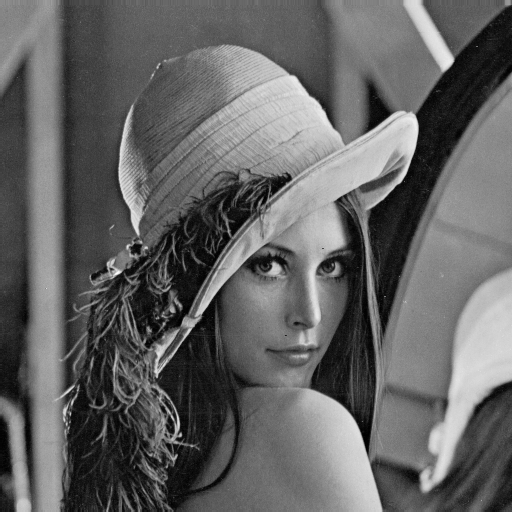

Mean of the noise:  0.01701260227083952
Standard deviation of the noise:  24.934759202554154


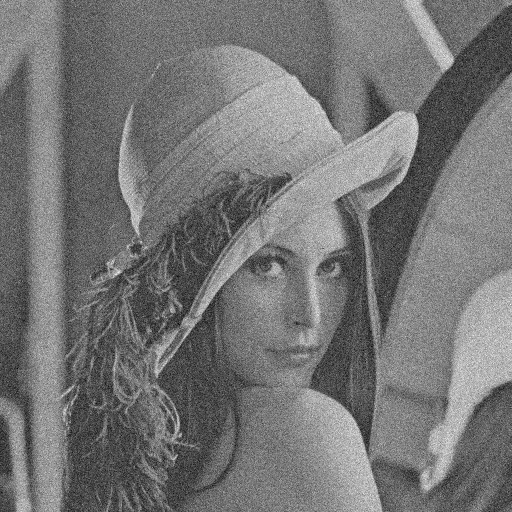

In [6]:
# voir l'image
viewimage(im,titre ='ORIGINALE')
#degrader une image

imb=degrade_image(im,25)

# voir l'image bruitée 
viewimage(imb,titre = 'BRUITEE')

In [7]:
# COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs 
# parametres de regularisation 

errq=[]
errvt=[]
erreur=[]
vk = np.arange(0, 0.25, 0.01);

for k in vk: 
    
    print (k)
    #restq=minimisation_quadratique(imb,10^(k));
    #errq.append[]=norm2(restq-myim);
    #restva=vartotale_Chambolle(imb,10**(k));
    restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    #errvt.append(norm2(restva-myim));
    
#plt.plot(10**vk,errvt);

0.0


NameError: name 'minimisation_quadratique' is not defined

In [ ]:
u1,en1 = minimise_TV_gradient(imb, 40, 1, 20)
u05,en05 = minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01 = minimise_TV_gradient(imb, 40, 0.1, 20)
#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)

In [ ]:
myim = imread('lena.tif')
imb = degrade_image(myim,25)
(u,energ) = minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2) = minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ)
plt.plot(energ2)

## 1. Débruitage par régularisation quadratique

Le modèle d'observation est

$$ v = u + b $$

où $ v $ est l'image observée (la donnée), $ u $ l'image parfaite et $ b $ le bruit.
On cherche à retrouver $ u $ comme minimiseur de l'énergie

$$ E_1(u) = \| u - v \|^2 + \lambda \| \nabla u \|^2 $$

Le premier terme est simplement la norme au carré de la différence entre $ u $ et $ v $. Le second est

$$ \iint \| \nabla u(x, y) \|^2 \, dx \, dy $$

C'est-à-dire l'intégrale du carré du gradient de l'image en tout point.

In [8]:
def resoud_quad_fourier(K, V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """
     
    n = len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx) = K[0].shape
    
    numer = np.vectorize(complex)(np.zeros((sy,sx)))
    denom = np.vectorize(complex)(np.zeros((sy,sx)))
    fft2 = np.fft.fft2
    ifft2 = np.fft.ifft2

    for k in range(n):
        fV = fft2(V[k])
        fK = fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer += np.conj(fK)*fV
        denom += abs(fK)**2
    return np.real(ifft2(numer/denom))



def minimisation_quadratique(v, lamb):
    """ minimise la fonctionnelle E1 du TP"""

    (sy,sx) = v.shape
    Kx = np.zeros((sy,sx))
    Ky = np.zeros((sy,sx))
    Kx[0,0] = 1
    Kx[0,1] = -1
    Ky[0,0] = 1
    Ky[1,0] = -1
    delta = np.zeros((sy,sx))

    delta[0,0] = 1.0
    s = lamb**0.5
    K = (s*Kx, s*Ky, delta)
    V = (np.zeros((sy,sx)), np.zeros((sy,sx)), v)
    return resoud_quad_fourier(K, V)


1.  Comment utiliser l'outil ``resoud_quad_fourier`` pour trouver le minimiseur de cette énergie (voir le programme ``minimisation_quadratique``) ?


→ The observation model is given by $ v = u + b $.

To estimate $u$, we formulate an energy expression that quantifies how far our estimate is from the observed image and also incorporates our prior knowledge about images, such as the expectation that they are smooth. This energy expression is:

$$ E_1(u) = \| u - v \|^2 + \lambda \| \nabla u \|^2 $$

- The first term, $ \| u - v \|^2 $, is the fidelity term. It measures the Euclidean distance (L2 norm) between the estimated image $ u $ and the observed image $ v $. We want this term to be small, which would mean that our estimate is close to the observation.

- The second term, $ \lambda \| \nabla u \|^2 $, is the regularization term. The gradient $ \nabla u $ measures how much the image changes at each point, and by squaring its norm, we are effectively penalizing large changes, enforcing smoothness in the estimated image. The parameter $ \lambda $ is a regularization coefficient that controls the trade-off between the fidelity to the observed data and the smoothness of the estimated image.


On the other hand, the gradient $ \nabla u $ can be approximated by discrete differences.
$ K_x \approx \begin{bmatrix} -1 & 1 & 0 \end{bmatrix} $ and $ K_y \approx \begin{bmatrix} -1 \\ 1 \\ 0 \end{bmatrix} $

Then, for the regularization term we have $ \lambda\| \nabla u \|^2 = \lambda\| K_x \ast u \|^2 + \lambda\| K_y \ast u \|^2 $.

And each part of the problem (Energy terms) can be expressed as follows:

$$ \|\delta \ast u - v\|^2 = \| u - v \|^2 $$

$$ \lambda \| K_x \ast u \|^2 = \lambda \| K_x \ast u - 0 \|^2 $$

$$ \lambda \| K_y \ast u \|^2 = \lambda \| K_y \ast u - 0 \|^2 $$

Then, the problem can be written as: $ E_1(u) = \sum_{i=1}^{3} \| K_i \ast u - V_i \|^2 $

→ Using Fourier transform we can transform the problem using the Parseval's theorem (easier to solve in this domain). 

The function `resoud_quad_fourier` receives two matrices $K$ and $V$ constructed using $K_x$, $K_x$, $v$ and the regularization term $\lambda$ of the previous exrpession, and solve the following problem:


- Taking the derivative of the previous equation and equaling to zero we have this expression:

$$ \sum \mathcal{F}(K_i)^* \cdot [\mathcal{F}(K_i) \cdot \mathcal{F}(u) - \mathcal{F}(V_i)] = 0 $$

- Solving for $ \mathcal{F}(u) $ we obtain:

$$ \mathcal{F}(u) = \frac{\sum \mathcal{F}(K_i)^* \cdot \mathcal{F}(V_i)}{\sum |\mathcal{F}(K_i)|^2} $$

- Taking the inverse fourier transform we found $u$ Which is the return of the `resoud_quad_fourier`.


2.  Décrire le résultat de ce débruitage lorsque $\lambda$ est très grand ou très petit.

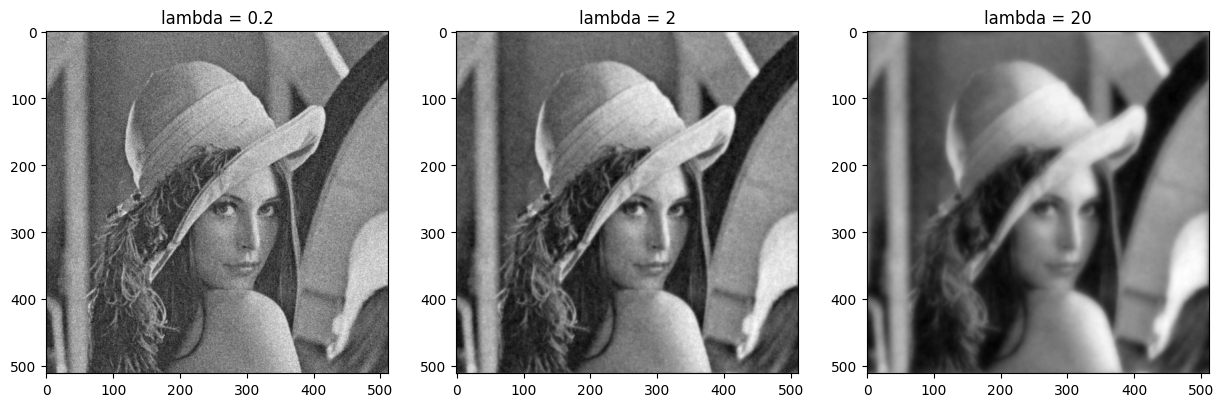

In [9]:
# Computing the result for lambda = 0.2, 2 and 20
u02 = minimisation_quadratique(imb, 0.2)
u2 = minimisation_quadratique(imb, 2)
u20 = minimisation_quadratique(imb, 20)

# Plotting the results in a 1x3 grid
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(u02, cmap='gray')
plt.title('lambda = 0.2')
plt.subplot(132)
plt.imshow(u2, cmap='gray')
plt.title('lambda = 2')
plt.subplot(133)
plt.imshow(u20, cmap='gray')
plt.title('lambda = 20')
plt.show()

When applying the regularization parameter lambda in the denoising algorithm, different values of lambda will affect the balance between fidelity to the observed image and the smoothness of the estimated image.

- **Lambda = 0.2**: At this point, we prioritize fidelity to the observed image over smoothness. The resulting image retain more of the noise because the regularization term does not sufficiently penalize the fluctuations in the image, which can be caused by noise.

- **Lambda = 2**: We could guess that this value is close to the optimal value because provide a good balance between reducing noise and maintaining image details. 
  
- **Lambda = 20**: The algorithm in this case heavily prioritize the smoothness of the image, which means that the image lost important details. The image is smoother than the others, leading to blurring and the loss of fine textures and edges.


3.  Après avoir ajouté un bruit d'écart type $\sigma = 5$ à l'image de lena, trouver (par dichotomie) le paramètre $\lambda$ pour lequel: 
  $$\| \tilde{u} - v \|^2 \approx \| u - v \|^2$$
C'est-à-dire le paramètre pour lequel l'image reconstruite $\tilde{u}$ est à la même distance de l'image dégradée $v$ que ne l'est l'image parfaite. (on respecte la norme du bruit : La norme du bruit est connue même quand on ne connaît pas l'image parfaite).

Mean of the noise:  0.0165175614634389
Standard deviation of the noise:  5.004014098235373


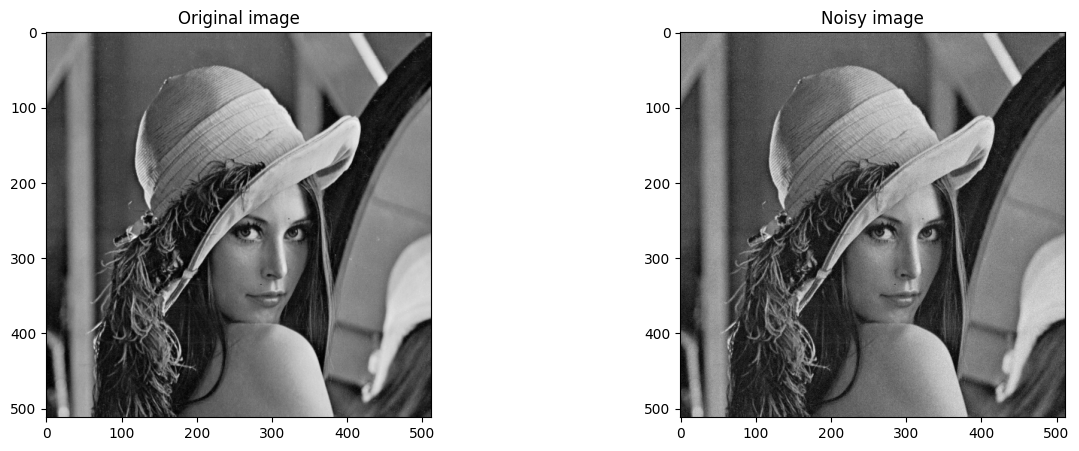

In [12]:
# Adding a gaussian noise to the image of standard deviation 5
std = 5
im5 = degrade_image(im, std)

# Ploting the two images 
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('Original image')
plt.subplot(122)
plt.imshow(im5, cmap='gray')
plt.title('Noisy image')
plt.show()

In [13]:
# Setting lambda_low and lambda_high between 0 and 10
lambda_low = 0
lambda_high = 10

# Iterate over the mid values of lambda
for k in range(20):
    lambda_mid = (lambda_low + lambda_high) / 2
    u_tilde = minimisation_quadratique(im5, lambda_mid)
    norm_diff_u_v = norm2(u_tilde - im5)**2 

    # The expected error norm2 due to the noise in the original image
    norm_diff_expected =  im.size * std
                          
    # Compare the error norm between the denoised and noisy images to the expected error norm
    if (norm_diff_u_v - norm_diff_expected) > 0:
        lambda_high = lambda_mid
    else:
        lambda_low = lambda_mid

    print(f'lambda_mid = {lambda_mid}, norm_diff_u_v = {norm_diff_u_v}, norm_diff_expected = {norm_diff_expected}')


lambda_mid = 5.0, norm_diff_u_v = 48242371.57120187, norm_diff_expected = 1310720
lambda_mid = 2.5, norm_diff_u_v = 32503941.996067617, norm_diff_expected = 1310720
lambda_mid = 1.25, norm_diff_u_v = 20655938.41537751, norm_diff_expected = 1310720
lambda_mid = 0.625, norm_diff_u_v = 12024973.84824207, norm_diff_expected = 1310720
lambda_mid = 0.3125, norm_diff_u_v = 6190257.727885092, norm_diff_expected = 1310720
lambda_mid = 0.15625, norm_diff_u_v = 2730340.633008246, norm_diff_expected = 1310720
lambda_mid = 0.078125, norm_diff_u_v = 1021018.0562412974, norm_diff_expected = 1310720
lambda_mid = 0.1171875, norm_diff_u_v = 1851073.6213702634, norm_diff_expected = 1310720
lambda_mid = 0.09765625, norm_diff_u_v = 1425977.7267417442, norm_diff_expected = 1310720
lambda_mid = 0.087890625, norm_diff_u_v = 1220302.9888768895, norm_diff_expected = 1310720
lambda_mid = 0.0927734375, norm_diff_u_v = 1322437.3618925803, norm_diff_expected = 1310720
lambda_mid = 0.09033203125, norm_diff_u_v = 127

4.  Écrire un algorithme pour trouver le paramètre $\lambda$ tel que $\| \tilde{u} - u \|^2$ soit minimale. (dans le cadre de ce TP on connaît l'image parfaite $u$, en général on ne la connaît pas). Commentaires ?

Lambda minimum:  1.2000000000000002
Minimum error:  28141413.47138877


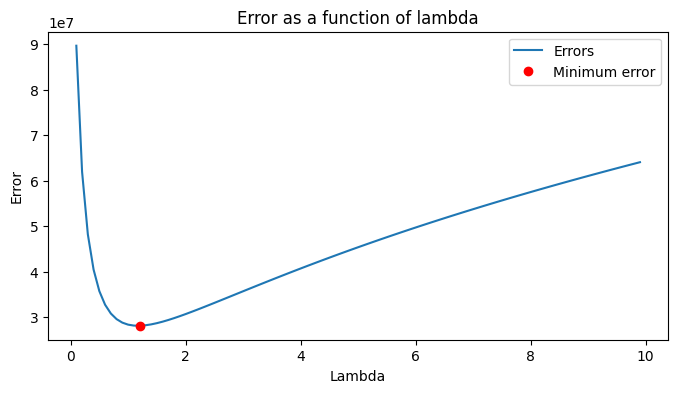

In [16]:
# Minimization of E1 using minimisation_quadratique and resoud_quad_fourier
myim = imread('lena.tif')

# Setting up a vector of lambdas
lambdas = np.arange(0.1, 10, 0.1)
# Setting up a vector of errors
errors = np.zeros(len(lambdas))

# Applying minimisation_quadratique for each lambda 
for i in range(len(lambdas)):
    u = minimisation_quadratique(imb, lambdas[i])
    errors[i] = norm2(u - myim)**2
    
# Taking the minimum of the errors
min_error = errors.min()
lambda_min = lambdas[errors.argmin()]

# Printing the results
print('Lambda minimum: ', lambda_min)
print('Minimum error: ', min_error)

# Plotting the errors as a function of lambda
plt.figure(figsize=(8, 4))
plt.plot(lambdas, errors)
plt.plot(lambdas[errors.argmin()], min_error, 'ro')
plt.legend(["Errors", "Minimum error"])
plt.title("Error as a function of lambda")
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.show()

## 2. Débruitage par variation totale

Dans cette section on utilise la variation totale comme terme de régularisation. Cela donne l'énergie

$$ E_2(u) = \|u - v\|^2 + \lambda \| \nabla u \|_1 $$

Le second terme est

$$ \iint \| \nabla u(x, y) \| \, dx \, dy $$


### 2.1 Descente de gradient

La première idée pour minimiser cette fonctionnelle est d'utiliser une descente de gradient. Nous allons voir que cela peut entraîner des problèmes numériques.

Le gradient de la fonctionnelle $ E_2 $ est donné par

$$ \nabla E_2(u) = 2(u - v) - \lambda \, \text{div} \left( \frac{\nabla u}{\| \nabla u \|} \right) $$

Il est calculé par la fonction `gradient_TV`. Utiliser le programme `minimise_TV_gradient` pour différentes valeurs du pas de descente. Atteignez-vous toujours le même minimum d'énergie? (le programme renvoie l'évolution de l'énergie).


### 2.2 Projection Chambolle

Le programme `vartotale_Chambolle` applique la méthode de Chambolle (expliquée dans le polycopié) au même problème posé par $E_2$. Utilisez ce programme et que constatez-vous quant à la vitesse de cette algorithme et sa précision (minimisation effective de $E_2$) par rapport à la descente de gradient. Dans la suite vous n’utiliserez plus que cette technique pour minimiser la fonctionnelle $E_2$.


## 3 Comparaison

Après avoir fixé une image bruitée par un bruit de 25. Trouver pour chacune des deux méthodes (TV et quadratique) le meilleur paramètre $ \lambda$ et comparez qualitativement le résultat obtenu par les deux méthodes pour le débruitage.

## 4 Déconvolution avec variation totale

Cette partie est optionnelle et ne peut pas être terminée pendant le temps du TP.
Ici nous comparons la déconvolution par variation totale avec la déconvolution quadratique. D’abord on donne la formule de l’observation :

$$ v = Au_0 + b $$

où $ u_0 $ est l’image parfaite, A est une convolution contre un noyau $ K $ et $ b $ un bruit blanc de puissance $ \sigma^2 $.

On considère les deux énergies de restauration. La première est quadratique, elle utilise comme régularisation l’énergie quadratique du champ de gradients.

$$ E_q(u) = \|Au - v\|^2 + \lambda \| \nabla u \|_2^2 $$

La seconde $ E_{TV} $ utilise la variation totale comme régularisation

$$ E_{TV}(u) = \|Au - v\|^2 + \lambda \| \nabla u \|_1 $$

La première se résout avec la fonction `resoud_quad_fourier`. Pour la seconde on utilise un algorithme de split en écrivant une nouvelle énergie qui dépend de deux variables. La première est l'image $ u $ recherchée. La seconde est $ d $, un champ de vecteur qui représente le gradient de $ u $. La manière la plus simple d'utiliser cette idée serait de minimiser l'énergie

$$ E_{\text{split}}(u, d) = \|Au - v\|^2 + \lambda \|d\|_1 + \gamma \| \nabla u - d \|^2 $$

Lorsque le paramètre $ \gamma $ devient grand le couple qui minimise cette énergie va vérifier $ \nabla u = d $ et alors $ u $ minimise $ E_{TV} $. L'avantage de cette énergie est que la minimisation par rapport à $ u $ (avec $ d $ fixe) l'énergie est quadratique et se résout facilement (Fourier). Si $ u $ est fixée la minimisation par rapport à $ d $ est facile aussi car

$$ E_{\text{split}}(u = \text{cst}, d) = \text{cst} + \sum_x ( \gamma \| \nabla u(x) - d(x) \|^2 + \lambda \|d(x)\|) $$

Pour chaque $ x $ (x est une position) on a une seule variable, le vecteur $ d(x) $. Or le minimiseur $ t $ (est un vecteur inconnu et $ w $ un vecteur connu constant) de

$$ \|t\| + \alpha \|t - w\|^2 $$

est

$$ t = \beta w \text{ et } \beta = \left\{ \begin{array}{ll}
0 & \text{si } \|w\| \leq \frac{1}{2\alpha} \\
1 - \frac{1}{2\alpha\|w\|} & \text{sinon}
\end{array} \right. \tag{1} $$

En prenant $ \alpha = \gamma/\lambda $ et $ w = \nabla u(x) $ et $ t = d(x) $ on trouve une manière de minimise $ E_{\text{split}} $ par rapport à $ d $ pour $ u $ fixé et c’est un algorithme rapide (quelques opérations pour chaque point $ x $).

Malheureusement, l’énergie $ E_{\text{split}} $ implique d’augmenter le paramètre $ \gamma $ sans vraiment savoir si $ \gamma $ est devenu assez grand pour forcer l’égalité $ \nabla u = d $.

Une énergie alternative est la suivante, elle fait intervenir un autre champ de vecteurs $ b_n $

$$ E_{\text{split}}^{n}(u, d) = \gamma\|d - \nabla u - b_n\|^2 + \lambda\|d(i, j)\|_1 + \|Au - v\|^2 $$

Ici $ \gamma $ est fixée et ce que l’on fait est de modifier $ b_n $ à chaque étape pour donner $ b_{n+1} $ ainsi au lieu de faire tendre $ \gamma $ vers l’infini on laisse le champ $ b_n $ évoluer de manière à forcer $ \nabla u = d $.

Voici l’algorithme :

1. $ n = 0, b_0 = 0 $ et $ d = 0 $
   Boucler sur les étapes
   (a) Minimiser $ E_{\text{split}}^n $ par rapport à $ u $.
   (b) Garder le $ u $ obtenu et minimiser $ E_{\text{split}}^n $ par rapport à $ d $
   (c) Faire $ b_{n+1} = b_n + \nabla u - d $ et incrémenter $ n $. Boucler

La démonstration de convergence de cet algorithme est difficile mais remarquons que s’il atteint une limite $ u, d $, alors $ d $ ne doit plus évoluer mais cela implique que $ b_n $ n’évolue plus (car $ d $ est proportionnel en tout point à $ b_n + \nabla u $, si $ b_n $ change alors $ d $ aussi). Mais pour que $ b_n $ n’évolue plus il faut que $ \nabla u - d $ soit nul.

### 4.1 Mise en application

Pour tester cette méthode il faut implémenter une fonction qui prend un champ de vecteur $ w $ et renvoie un champ de vecteur $ t $ comme dans l'équation (1). On appelle cette fonction `softthresh(w, \alpha)`.

Une autre chose à laquelle il faut faire attention est que la convolution doit être appliquée par une multiplication en Fourier ce qui revient à supposer que l'image est périodique.
On appelle `convol` la fonction convolution on fait ceci :

Partie préparation: Prendre une image parfaite et lui appliquer `convol` et ajouter du bruit. Typiquement on prend un flou de noyau une gaussienne de largeur 1,5 pixels et un bruit de 2 ou 3 (pour une image de 255 niveaux de gris).

**algorithme**
Commencer par $ b_0 = 0 $ et $ d = 0 $.
Utiliser `resoud_quad_fourier` pour minimiser $ E_{\text{split}}^n $ par rapport à $ u $.
Utiliser `softthresh(w, \alpha)` pour minimiser $ E_{\text{split}} $ par rapport à $ d $.
Modifier $ b_n $, comme en (c) plus haut.
Recommencer.

Dans cet article en ligne [http://www.ipol.im/pub/art/2012/g-tvdc/](http://www.ipol.im/pub/art/2012/g-tvdc/), les auteurs expliquent qu’une bonne valeur à laquelle fixer $ \gamma $ est 5. Mais dans cet article ils manipulent des images à valeurs réelles entre 0 et 1. Expliquer pourquoi un bon paramètre $ \gamma $ pour les images entre 0 et 255 est $ 5/(255^2) $.

Plus généralement, si on suppose que pour $ v $ et $ \sigma $ (le bruit) données les bons paramètres sont $ \lambda_0 $ et $ \gamma_0 $, quels sont les bons paramètres pour $ v' = 255v $ et $ \sigma' = 255\sigma $.
